In [1]:
from pybaseball import statcast
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

### Use statcast to get info on the rates of events
Grab 1 week of data per month for decent representative sample

In [2]:
# Using 2016 data since that's the most recent in associated lahman database
may_df = statcast(start_dt='2018-05-15', end_dt='2018-05-22')
june_df = statcast(start_dt='2018-06-15', end_dt='2018-06-22')
july_df = statcast(start_dt='2018-07-01', end_dt='2018-07-07') # avoids All star break
august_df = statcast(start_dt='2018-08-15', end_dt='2018-08-22') 


This is a large query, it may take a moment to complete
Completed sub-query from 2018-05-15 to 2018-05-20
Completed sub-query from 2018-05-21 to 2018-05-22
This is a large query, it may take a moment to complete
Completed sub-query from 2018-06-15 to 2018-06-20
Completed sub-query from 2018-06-21 to 2018-06-22
This is a large query, it may take a moment to complete
Completed sub-query from 2018-07-01 to 2018-07-06
Completed sub-query from 2018-07-07 to 2018-07-07
This is a large query, it may take a moment to complete
Completed sub-query from 2018-08-15 to 2018-08-20
Completed sub-query from 2018-08-21 to 2018-08-22


In [3]:
stats = pd.concat([may_df, june_df, july_df, august_df])

In [4]:
stats.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,67,SL,2018-05-22,89.8,-2.6624,5.5526,Edwin Diaz,543760.0,621242.0,strikeout,...,2.0,3.0,2.0,3.0,3.0,2.0,2.0,3.0,Standard,Standard
1,73,FF,2018-05-22,95.7,-2.7134,5.5129,Edwin Diaz,543760.0,621242.0,NaN,...,2.0,3.0,2.0,3.0,3.0,2.0,2.0,3.0,Standard,Standard
2,78,FF,2018-05-22,97.4,-2.7590,5.3907,Edwin Diaz,543760.0,621242.0,NaN,...,2.0,3.0,2.0,3.0,3.0,2.0,2.0,3.0,Standard,Standard
3,84,FF,2018-05-22,96.2,-2.6647,5.5366,Edwin Diaz,543760.0,621242.0,NaN,...,2.0,3.0,2.0,3.0,3.0,2.0,2.0,3.0,Standard,Standard
4,94,SL,2018-05-22,87.6,-2.7418,5.6177,Edwin Diaz,543760.0,621242.0,NaN,...,2.0,3.0,2.0,3.0,3.0,2.0,2.0,3.0,Standard,Standard


In [5]:
stats.events.dropna().value_counts()

field_out                       12610
strikeout                        6908
single                           4501
walk                             2457
double                           1470
home_run                          949
force_out                         618
grounded_into_double_play         592
hit_by_pitch                      317
field_error                       276
sac_fly                           203
sac_bunt                          144
triple                            129
double_play                        79
fielders_choice_out                49
strikeout_double_play              37
caught_stealing_2b                 33
fielders_choice                    18
other_out                           9
pickoff_caught_stealing_2b          7
catcher_interf                      4
pickoff_1b                          3
caught_stealing_3b                  3
pickoff_caught_stealing_home        2
caught_stealing_home                2
pickoff_2b                          2
pickoff_caug

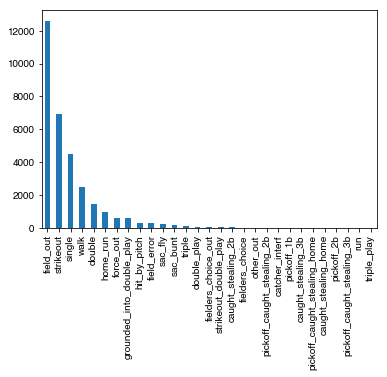

In [6]:
stats.events.dropna().value_counts().plot(kind='bar')

#### Now these need to map this to the existing dice roll options

In [7]:
original_outcomes = ['double', 'single', 'base on error', 'base on balls', 'strike', 'foul out', 'out at 1st', 'fly out', 'double play', 'triple', 'home run' ]
# I think the handling of strikes vs balls is inconsistent. We're going to drop those
original_outcomes = [i for i in original_outcomes if i is not 'strike']

Now create the mapping. I'll try to comment less obvious ones. We'll have to drop things that aren't handled in the simulation correctly, or map them, but limited number of dice throws and need to be representative of frequency so creating new mappings in the simulation isn't a great idea

In [8]:
statcast_to_outcome_mapping ={
    'field_out' : 'out at 1st',
    'strikeout' : 'strike out', # I made my own "strikeout" result for when 3 strikes happen back to back. Handled the same as out at 1st, could sub it too
    'single' : 'single',
    'walk' : 'base on balls',
    'double' : 'double',
    'home_run': 'home run',
    'force_out': 'out at 1st',
    'grounded_into_double_play': 'double play',
    'hit_by_pitch': 'base on balls', # effectively the same thing
    'field_error': 'base on error',
    'sac_fly': 'DROP', # Sacrifices aren't handled well in the existing simulation. We can drop it, I suppose
    'sac_bunt': 'DROP',
    'triple': 'triple',
    'double_play': 'double play',
    'fielders_choice_out': 'DROP', # This unfortunately isn't handled well in the simulation either, since it would put out the leading runner
    'strikeout_double_play': 'DROP', # same
    'caught_stealing_2b': 'DROP', # same
    'fielders_choice' : 'DROP', #same
    'other_out': 'DROP', # This could be a fair amount of other things, not clear how it would progress the state
    'pickoff_caught_stealing_2b': 'DROP',
    'pickoff_1b': 'DROP',
    'caught_stealing_3b': 'DROP',
    'pickoff_2b': 'DROP',
    'catcher_interf': 'base on balls', # Same as a walk
    'caught_stealing_home': 'DROP',
    'pickoff_caught_stealing_home': 'DROP',
    'triple_play': 'DROP',
    'run': 'DROP', # This is ambiguous and there's only 1 so not a big deal to drop it
}

A note here, we don't have anything mapped to "foul out." These are absorbed into "out at first." We'll just call the "out at 1st" outcome a generic "field out" compared to strike outs.

In [9]:
for key in statcast_to_outcome_mapping:
    if statcast_to_outcome_mapping[key] == 'out at 1st':
        statcast_to_outcome_mapping[key] = 'field out'

In [10]:
new_outcomes = stats.events.map(statcast_to_outcome_mapping)
stats['dice_outcome'] = new_outcomes
reduced_dataframe =  stats.query('dice_outcome != "DROP"')

In [11]:
freq = reduced_dataframe.dice_outcome.dropna().value_counts()
freq

field out        13228
strike out        6908
single            4501
base on balls     2778
double            1470
home run           949
double play        671
base on error      276
triple             129
Name: dice_outcome, dtype: int64

We've got the frequency of each dice event in real life baseball - let's plot it

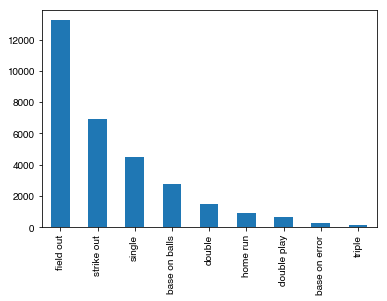

In [12]:
freq.plot(kind='bar')

We need to fit these within a scale of 21 dice roll options

Just to be sure I know how statistics work - quickly show of dice roll probabilties 

In [13]:
import random
rolls = []
for i in range(0,100000):
    dice_1 = random.randrange(1,7)
    dice_2 = random.randrange(1,7)
    rolls.append(tuple(sorted((dice_1,dice_2))))

([<matplotlib.axis.XTick at 0x115af4668>,
 <a list of 21 Text xticklabel objects>)

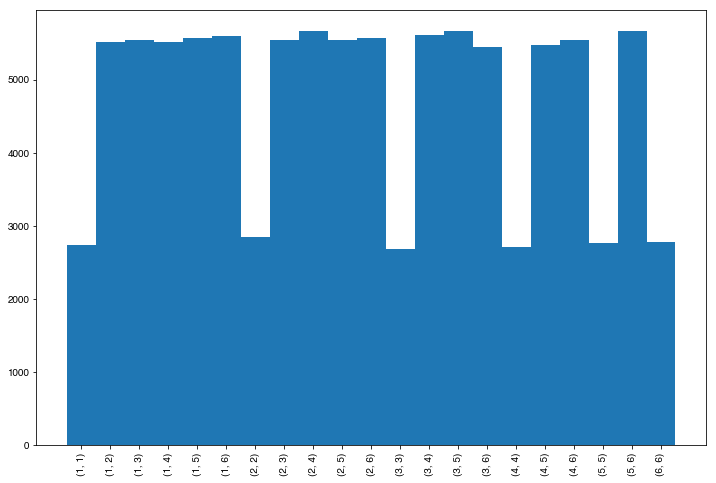

In [14]:
from collections import Counter
k = Counter(rolls)

fig = plt.figure(figsize=(12,8))
x=range(len(k))
y=[k[key] for key in sorted(k)]
xlabels=[str(t) for t in sorted(k)]
plt.bar(x,y,width=1 )
# set the labels at the middle of the bars
plt.xticks(x,xlabels, rotation='vertical')

Doubles are half as likely as others (this is because doubles only happen in one configuration - first shows value, second shows same value, while non doubles can be A,B or B,A)

So rather than considering it on a scale of 21 possibilities, we consider it on a scale of 36, one for each dice configuration

In [15]:
# Try to just make triple the lowest denominator
normed_freq = freq/119
normed_freq

field out        111.159664
strike out        58.050420
single            37.823529
base on balls     23.344538
double            12.352941
home run           7.974790
double play        5.638655
base on error      2.319328
triple             1.084034
Name: dice_outcome, dtype: float64

In [16]:
normed_freq.sum()

259.74789915966386

Okay, so we're not going to get this perfect obviously. So let's assign the very rare ones to double digits then work from there

In [17]:
updated_assignments = {
    (1,1) : 'triple',
    (2,2) : 'base on error',
    (3,3) : 'double play',
    (4,4) : 'home run',
}

In [18]:
update_freq = normed_freq
for i in updated_assignments:
    update_freq = update_freq.drop(updated_assignments[i])

In [19]:
update_freq

field out        111.159664
strike out        58.050420
single            37.823529
base on balls     23.344538
double            12.352941
Name: dice_outcome, dtype: float64

In [20]:
norm = update_freq/12.34
print(norm.round())
print ("sum: ", norm.round().sum()) 


field out        9.0
strike out       5.0
single           3.0
base on balls    2.0
double           1.0
Name: dice_outcome, dtype: float64
sum:  20.0


okay, so we now have about 20 "outcomes" to map to 32 spaces. Remember that non-doubles count as 2 spaces

In [21]:
more_updated_assignments = {
    (5,5) : 'double', # 1 double achieved

    (6,6) : 'strike out',
    (1, 2): 'strike out',
    (1, 3): 'strike out', # 5 strike outs achieved

    (1, 4): 'base on balls', # 2 base on balls achieved

    (1, 5): 'single',
    (1, 6): 'single', # odd number for single, but out of doubles, so we'll add one extra...

    (2, 3): 'field out',
    (2, 4): 'field out',
    (2, 5): 'field out',
    (2, 6): 'field out',
    (3, 4): 'field out', # same for singles but for outs.
    
    # okay, now I've got 5 more spaces to map. What we'll do is start with a baseline cancelling with generally docile events - mix of singles, outs roughly cancelling.
    (3, 5): 'field out',
    (3, 6): 'strike out',
    (4, 5): 'single',
    (4, 6): 'base on balls',
    (5, 6): 'single',
    
}

In [22]:
# Merge dictionaries
final_new_outcomes = {**updated_assignments, **more_updated_assignments}

To figure out how to best approximate the real game, we need to find the average scoring for real baseball.....

## Find Actual Distribution
To motivate how to better map those last few slots and to get as close to a real game as possible, we need to find the actual distribution of runs/game from MLB

In [23]:
from pybaseball.retrosheet import *

In [24]:
logs = season_game_logs(2018)

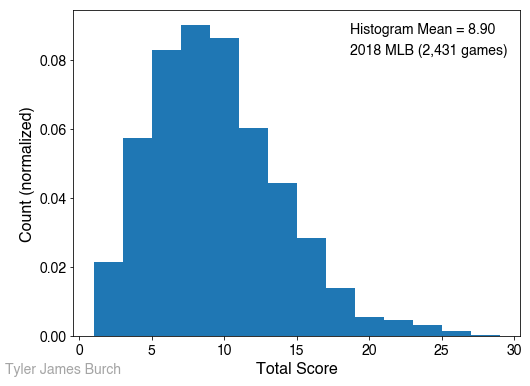

In [43]:
total_score = logs['home_score'] + logs['visiting_score']

fig = plt.figure(figsize=(8,6))
ax = plt.gca()
total_score.hist(ax=ax, density=True, bins=np.arange(total_score.min(),total_score.max(),2))
plt.xlabel('Total Score', fontsize=16)
plt.ylabel('Count (normalized)', fontsize=16)
plt.title('')
ax.tick_params(axis='both', which='major', labelsize=14)

mean_total_score = total_score.mean()
num_games = total_score.count()
def leg_add_histo_info(mean_total_score, num_games, ax):
    s1 = 'Histogram Mean = %.2f'%mean_total_score
    s2 = '2018 MLB ({:,} games)'.format(num_games)
    extra1 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0, label=s1)
    extra2 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0, label=s2)
    handles, labels = ax.get_legend_handles_labels()
    for obj, label in zip([extra1,extra2], [s1,s2]):
        handles.append(obj)
        labels.append(label)
    return handles, labels
        

handles, labels = leg_add_histo_info(mean_total_score,num_games, ax)  
plt.legend(handles=handles, labels=labels, loc='best',fontsize=14, frameon=False)
ax.grid(b=False)

# add watermark
plt.annotate(s="Tyler James Burch", xy=(.01,.033), xycoords='figure fraction',
                 textcoords='figure fraction', color='grey',alpha=0.7, fontsize=14)

plt.savefig("plots/mlb_scores.png")

### Run simulation with new values


In [26]:
from simulator import *

In [27]:
# approximate field out to fly out
subbed_dict = {}
for key in final_new_outcomes:
    if final_new_outcomes[key] == 'field out':
            subbed_dict[key] = 'fly out'
    else: subbed_dict[key] = final_new_outcomes[key]

In [28]:
subbed_dict

{(1, 1): 'triple',
 (2, 2): 'base on error',
 (3, 3): 'double play',
 (4, 4): 'home run',
 (5, 5): 'double',
 (6, 6): 'strike out',
 (1, 2): 'strike out',
 (1, 3): 'strike out',
 (1, 4): 'base on balls',
 (1, 5): 'single',
 (1, 6): 'single',
 (2, 3): 'fly out',
 (2, 4): 'fly out',
 (2, 5): 'fly out',
 (2, 6): 'fly out',
 (3, 4): 'fly out',
 (3, 5): 'fly out',
 (3, 6): 'strike out',
 (4, 5): 'single',
 (4, 6): 'base on balls',
 (5, 6): 'single'}

In [29]:
def run_sim(outcome_map, num_simulations):
    with open('data/retooled_run_simulations.csv','w') as f:
        f.write('simulation_no,home_score,away_score,total_score\n')
        for i in range(0,num_simulations):
            simulation = Game()
            simulation.simulate(outcome_map)
            home_score = sum(simulation.home_box_score)
            away_score = sum(simulation.away_box_score)
            total_s = home_score + away_score
            f.write('%i,%i,%i,%i\n' % (i, home_score, away_score, total_s))

run_sim(subbed_dict,10000)


In [30]:
new_sim = pd.read_csv('data/retooled_run_simulations.csv')

In [31]:
print(new_sim['total_score'].count())
print(new_sim['total_score'].mean())

10000
19.8689


So we're down to 19 on average - This is closer than before! So let's make some of the positive ones negative, then rerun.

Truthfully here I played with these values a bit until I got the mean ~ the same as actual

In [32]:
# (4, 5): 'single' -> out
subbed_dict[(4, 5)] = 'fly out'
# (5, 6): 'single' -> out
subbed_dict[(4, 6)] = 'strike out'
# (5, 6): 'single' -> out
subbed_dict[(5, 6)] = 'base on balls'

In [33]:
run_sim(subbed_dict,100000)
new_sim = pd.read_csv('data/retooled_run_simulations.csv')
print(new_sim['total_score'].count())
print(new_sim['total_score'].mean())

100000
9.47868


Nice! We've designed a game less than 0.6 runs/game away from the real MLB runs/game on average. Let's see how it looks in terms of the distribution. 

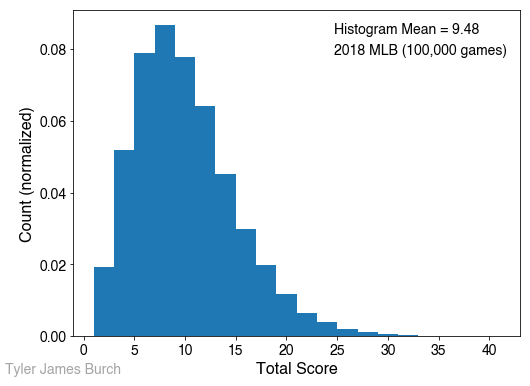

In [42]:
new_total_score = new_sim['total_score']

fig = plt.figure(figsize=(8,6))
ax = plt.gca()
h1 = new_total_score.hist(ax=ax, density=True, bins=np.arange(new_total_score.min(),new_total_score.max(),2))
plt.xlabel('Total Score', fontsize=16)
plt.ylabel('Count (normalized)', fontsize=16)
plt.title('')
ax.tick_params(axis='both', which='major', labelsize=14)

new_mean_total_score = new_total_score.mean()
new_num_games = new_total_score.count()

handles, labels = leg_add_histo_info(new_mean_total_score,new_num_games, ax)  
plt.legend(handles=handles, labels=labels, loc='best',fontsize=14, frameon=False)
ax.grid(b=False)

# add watermark
plt.annotate(s="Tyler James Burch", xy=(.01,.033), xycoords='figure fraction',
                 textcoords='figure fraction', color='grey',alpha=0.7, fontsize=14)

plt.savefig("plots/updated_simulation_hist.png")

The final solution dictionary is as follows:

In [35]:
subbed_dict

{(1, 1): 'triple',
 (2, 2): 'base on error',
 (3, 3): 'double play',
 (4, 4): 'home run',
 (5, 5): 'double',
 (6, 6): 'strike out',
 (1, 2): 'strike out',
 (1, 3): 'strike out',
 (1, 4): 'base on balls',
 (1, 5): 'single',
 (1, 6): 'single',
 (2, 3): 'fly out',
 (2, 4): 'fly out',
 (2, 5): 'fly out',
 (2, 6): 'fly out',
 (3, 4): 'fly out',
 (3, 5): 'fly out',
 (3, 6): 'strike out',
 (4, 5): 'fly out',
 (4, 6): 'strike out',
 (5, 6): 'base on balls'}

Overlaying the solutions:

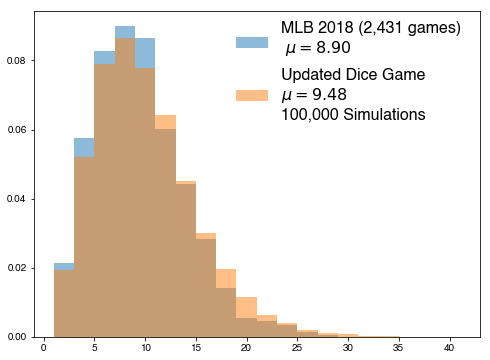

In [39]:
fig =plt.figure(figsize=(8,6))
ax = plt.gca()
h1 = total_score.hist(ax=ax, density=True, bins=np.arange(total_score.min(),total_score.max(),2), alpha= 0.5, label="MLB 2018 ({0:,} games) \n $\mu={1:.2f}$".format(num_games, mean_total_score))
h2 = new_total_score.hist(ax=ax, density=True, bins=np.arange(new_total_score.min(),new_total_score.max(),2), alpha=0.5, label="Updated Dice Game \n$\mu={0:.2f}$ \n{1:,} Simulations".format(new_mean_total_score, new_num_games))
plt.legend(frameon=False, fontsize=16)
ax.grid(b=False)
plt.savefig('plots/mlb_simulation_overlay.png')

These actually look pretty good! Seems our new game models the true distribution of runs scored in baseball fairly well!